# Predicting mechanosensing functionalities from protein sequences (Yumei Chen, Yizhong Hu) - ML

In [1]:
!pip install tensorflow

     |████████████████████████████████| 175.3 MB 1.5 MB/s eta 0:00:01    |███▋                            | 20.0 MB 241 kB/s eta 0:10:45     |██████████████████▋             | 102.1 MB 3.1 MB/s eta 0:00:24     |██████████████████████████████▉ | 168.7 MB 1.5 MB/s eta 0:00:05
     |████████████████████████████████| 3.0 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 917 kB/s eta 0:00:01
     |████████████████████████████████| 104 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 749 kB/s eta 0:00:01
     |████████████████████████████████| 63 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 1.5

In [3]:
!pip install keras

     |████████████████████████████████| 377 kB 614 kB/s eta 0:00:01
     |████████████████████████████████| 50 kB 1.9 MB/s eta 0:00:01


In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.regularizers import l2

import gc

Using TensorFlow backend.


In [3]:
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Gathering and preparation

In [4]:
def datainput(filename):
    f = open(filename,'r')
    seq = {}
    for line in f:
        if line.startswith('>'):
                name=line.replace('>','').split()[0]
                seq[name]=''
        else:
                seq[name]+=line.replace('\n','').strip()
    return seq

In [5]:
seq1human = datainput('/Users/yumeichen/Desktop/Data/Mamaliam/uniprot-mechanosensitive-filtered-organism__Homo+sapiens+(Human)+[9606--.fasta.txt')
seq2human = datainput('/Users/yumeichen/Desktop/Data/Mamaliam/uniprot-cellular+response+to+mechanical+stimulus+reviewed_yes+organism__Ho--.fasta.txt')
seq1mouse = datainput('/Users/yumeichen/Desktop/Data/Mamaliam/uniprot-mechanosensitive-filtered-reviewed_yes+AND+organism__Mus+musculus+--.fasta.txt')
seq2mouse = datainput('/Users/yumeichen/Desktop/Data/Mamaliam/uniprot-cellular+response+mechanical+stimulus+NOT+mechanosensitive+reviewed_ye--.fasta.txt')
seq1rat = datainput('/Users/yumeichen/Desktop/Data/Mamaliam/uniprot-mechanosensitive-filtered-organism__Rattus+norvegicus+(Rat)+[1--.fasta.txt')
seq2rat = datainput('/Users/yumeichen/Desktop/Data/Mamaliam/uniprot-cellular+response+mechanical+stimulus+NOT+mechanosensitive-filtered-orga--.fasta.txt')

In [6]:
seq1ecoli = datainput('/Users/yumeichen/Desktop/Data/Bacteria and plant/uniprot-mechanosensitive+AND+reviewed_yes+AND+organism__Escherichia+coli%2--.fasta.txt')
seq1athe = datainput('/Users/yumeichen/Desktop/Data/Bacteria and plant/mechanosensitive-A.thaliana.txt')

In [7]:
print ('human sample1:',len(seq1human))
print ('human sample2:',len(seq2human))
print ('mouse sample1:',len(seq1mouse))
print ('mouse sample2:',len(seq2mouse))
print ('rat sample1:',len(seq1rat))
print ('rat sample2:',len(seq2rat))
print ('E coli sample1:',len(seq1ecoli))
print ('A the sample1:',len(seq1athe))

human sample1: 16
human sample2: 157
mouse sample1: 15
mouse sample2: 164
rat sample1: 6
rat sample2: 176
E coli sample1: 29
A the sample1: 25


In [8]:
positivem = {}
for k,v in seq1human.items():
    positivem[k] = v
    
for k,v in seq2human.items():
    positivem[k] = v
    
for k,v in seq1mouse.items():
    positivem[k] = v
    
for k,v in seq2mouse.items():
    positivem[k] = v
    
for k,v in seq1rat.items():
    positivem[k] = v
    
for k,v in seq2rat.items():
    positivem[k] = v
    
print('positive mamaliam samples:', len(positivem))

positive mamaliam samples: 534


In [9]:
positiveb = {}
for k,v in seq1ecoli.items():
    positiveb[k] = v
    
for k,v in seq1athe.items():
    positiveb[k] = v
    
print('positive bacteria and plant samples:', len(positiveb))

positive bacteria and plant samples: 54


In [10]:
negativehuman = datainput('/Users/yumeichen/Desktop/Data/negative/uniprot-yourlist_M20200430DA437993067D6F64326E5E763500BDED17EC2DV.fasta.txt')
negativerat = datainput('/Users/yumeichen/Desktop/Data/negative/uniprot-yourlist_M20200430DA437993067D6F64326E5E763500BDED17ED97S.fasta.txt')
negativemouse = datainput('/Users/yumeichen/Desktop/Data/negative/uniprot-yourlist_M20200430E5A08BB0B2D1C45B0C7BC3B55FD2655683F1A8I.fasta.txt')

In [11]:
negatives = {}
for k,v in negativehuman.items():
    negatives[k] = v
    
for k,v in negativerat.items():
    negatives[k] = v
    
for k,v in negativemouse.items():
    negatives[k] = v
print('negative samples:', len(negatives))

negative samples: 549


In [12]:
a = pd.DataFrame.from_dict(positivem,orient='index',columns = ['sequence'])
a = a.reset_index().rename(columns = {'index':'id'})
b = pd.DataFrame.from_dict(negatives,orient='index',columns = ['sequence'])
b = b.reset_index().rename(columns = {'index':'id'})

In [13]:
a.head()

,id,sequence
0,sp|Q92508|PIEZ1_HUMAN,MEPHVLGAVLYWLLLPCALLAACLLRFSGLSLVYLLFLLLLPWFPG...
1,sp|Q9H5I5|PIEZ2_HUMAN,MASEVVCGLIFRLLLPICLAVACAFRYNGLSFVYLIYLLLIPLFSE...
2,sp|O94886|CSCL1_HUMAN,MMDSPFLELWQSKAVSIREQLGLGDRPNDSYCYNSAKNSTVLQGVT...
3,sp|Q8TDI7|TMC2_HUMAN,MSHQVKGLKEEARGGVKGRVKSGSPHTGDRLGRRSSSKRALKAEGT...
4,sp|Q13936|CAC1C_HUMAN,MVNENTRMYIPEENHQGSNYGSPRPAHANMNANAAAGLAPEHIPTP...


In [14]:
b

,id,sequence
0,sp|P52594|AGFG1_HUMAN,MAASAKRKQEEKHLKMLRDMTGLPHNRKCFDCDQRGPTYVNMTVGS...
1,sp|Q9UKV8|AGO2_HUMAN,MYSGAGPALAPPAPPPPIQGYAFKPPPRPDFGTSGRTIKLQANFFE...
2,sp|Q9NZN5|ARHGC_HUMAN,MSGTQSTITDRFPLKKPIRHGSILNRESPTDKKQKVERIASHDFDP...
3,sp|O60885|BRD4_HUMAN,MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPP...
4,sp|P43155|CACP_HUMAN,MLAFAARTVVKPLGFLKPFSLMKASSRFKAHQDALPRLPVPPLQQS...
...,...,...
544,sp|Q00896|A1AT3_MOUSE,MTPSISWGLLLLAGLCCLVPSFLAEDVQETDTSQKDQSPASHEIAT...
545,sp|Q80ZQ9|ABITM_MOUSE,MEELRCPEAKLAPPEVVIATEAPPPSLVDRYFTRWYKADVKGKPCE...
546,sp|P05202|AATM_MOUSE,MALLHSSRILSGMAAAFHPGLAAAASARASSWWTHVEMGPPDPILG...
547,sp|Q99PU5|ACBG1_MOUSE,MPRGSEAGYCCLSRDSNMPDSRDDQQQGASLGTSQDNSQTSSLIDG...


In [15]:
a['feature'] = 'positive'
b['feature'] = 'negative'

In [16]:
#a.to_excel('/Users/yumeichen/Desktop/positivem.xls')
#b.to_excel('/Users/yumeichen/Desktop/negativeh.xls')
#c.to_excel('/Users/yumeichen/Desktop/combine.xls')

# Sequence counts

In [17]:
# Length of sequence in positive sample.
sequencelen = a['sequence'].str.len()
sequencemax_argmax = sequencelen[sequencelen == sequencelen.max()].index

In [18]:
sequencemax_argmax

Int64Index([93], dtype='int64')

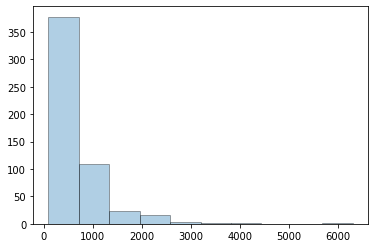

In [19]:
import matplotlib.pyplot as plt
plt.hist(sequencelen, edgecolor='k', alpha=0.35)
plt.show()

In [20]:
sequencelen

0      2521
1      2752
2       807
3       906
4      2221
       ... 
529     199
530     225
531     213
532     731
533     385
Name: sequence, Length: 534, dtype: int64

In [21]:
a['sequencelen'] = sequencelen

In [22]:
# Length of sequence in negative sample.
nsequencelen = b['sequence'].str.len()
nsequencemax_argmax = nsequencelen[nsequencelen == nsequencelen.max()].index

In [23]:
nsequencemax_argmax

Int64Index([52], dtype='int64')

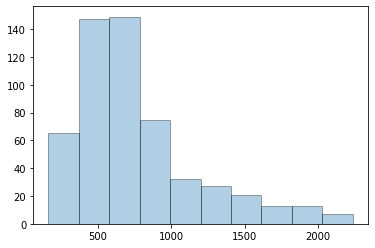

In [24]:
plt.hist(nsequencelen, edgecolor='k', alpha=0.35)
plt.show()

In [25]:
b['sequencelen'] = nsequencelen

# remove long sequence

In [26]:
a2 = a.drop(a[a['sequencelen'] >= 3000].index)

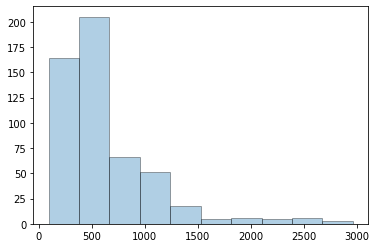

In [27]:
plt.hist(a2['sequencelen'], edgecolor='k', alpha=0.35)
plt.show()

In [28]:
c = pd.concat( [a2,b], axis=0 )

In [29]:
c = c.reset_index()

In [30]:
max(c['sequencelen'])

2959

In [31]:
from sklearn.preprocessing import LabelBinarizer

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [32]:
max_length = 2959
seqs = c.sequence.values
#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
x1 = sequence.pad_sequences(X, maxlen=max_length)
x2 = sequence.pad_sequences(X, maxlen=max_length,padding='post')

In [34]:
#x1 pre padding, x2 post padding
#combine pre and post padding
X_new = np.hstack((x1,x2))

In [35]:
lengths = [len(s) for s in seqs]
max(lengths)

2959

In [36]:
# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(c.feature)

In [37]:
Y.shape

(1078, 1)

In [38]:
#x1 pre padding numercial
#x2 post padding numercial
#X_new combine numercial

# One hot encoding of sequences
X_binary = to_categorical(X_new)
X_binary.shape

(1078, 5918, 21)

In [37]:
#reduce dimension directly
#nsamples, nx, ny = X.shape
#X = X_binary.reshape((nsamples,nx*ny))

In [39]:
# pca
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.random_projection import SparseRandomProjection
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam

# PCA
pca = PCA(n_components = 1)
X_binary_pca = np.zeros((len(X_binary),len(X_binary[0])))

for i in range(0,len(X_binary)):
    entry = X_binary[i]
    entry_pca = pca.fit_transform(entry)
    X_binary_pca[i,:] = entry_pca.reshape(len(entry_pca))
print(X_binary_pca.shape)
X_binary_pca[0]

(1078, 5918)


array([0.82992852, 0.82992977, 0.82992989, ..., 0.82992989, 0.82992989,
       0.82992989])

In [40]:
# adding polarity, charge and hydrophobicity properties as additional entries
(a,b) = X_new.shape
X_chem = np.zeros(((a,b,3)))
#X_chem(:,:,1) indicate polarity
#X_chem(:,:,2) indicate charge
#X_chem(:,:,3) indicate hydrophobicity

for i in range(0,a):
    for j in range(0,b):
        if X_new[i,j]==1:#L
            X_chem[i][j][2]=1
        if X_new[i,j]==2:#S
            X_chem[i][j][0]=1
        if X_new[i,j]==3:#G
            X_chem[i][j][2]=1
        if X_new[i,j]==4:#A
            X_chem[i][j][2]=1
        if X_new[i,j]==5:#E
            X_chem[i][j][1] = 1
        if X_new[i,j]==6:#P
            X_chem[i][j][2]=1
        if X_new[i,j]==7:#V
            X_chem[i][j][2]=1
        if X_new[i,j]==8:#K
            X_chem[i][j][1]=1
        if X_new[i,j]==9:#R
            X_chem[i][j][1]=1
        if X_new[i,j]==10:#T
            X_chem[i][j][0]=1
        if X_new[i,j]==11:#D
            X_chem[i][j][1]=1
        if X_new[i,j]==12:#I
            X_chem[i][j][2]=1
        if X_new[i,j]==13:#Q
            X_chem[i][j][0]=1
        if X_new[i,j]==14:#F
            X_chem[i][j][2]=1
        if X_new[i,j]==15:#N
            X_chem[i][j][0]=1
        if X_new[i,j]==16:#Y
            X_chem[i][j][0]=1
        if X_new[i,j]==17:#H
            X_chem[i][j][0]=1
        if X_new[i,j]==18:#M
            X_chem[i][j][0]=1
            X_chem[i][j][2]=1
        if X_new[i,j]==19:#C
            X_chem[i][j][0]=1
        if X_new[i,j]==20:#W
            X_chem[i][j][0]=1
            
X_binary_chem = np.c_[X_binary,X_chem]      
print(X_binary.shape)
print(X_chem.shape)
print(X_binary_chem.shape)

(1078, 5918, 21)
(1078, 5918, 3)
(1078, 5918, 24)


In [41]:
# reduce dimensionality of X_binary_chem
pca = PCA(n_components = 1)
X_binary_chem_pca = np.zeros((len(X_binary_chem),len(X_binary_chem[0])))

for i in range(0,len(X_binary_chem)):
    entry = X_binary_chem[i]
    entry_pca = pca.fit_transform(entry)
    X_binary_chem_pca[i,:] = entry_pca.reshape(len(entry_pca))
print(X_binary_chem_pca.shape)
X_binary_chem_pca[0]

(1078, 5918)


array([-0.35347901, -0.35347901, -0.35347901, ..., -0.35347901,
       -0.35347901, -0.35347901])

In [42]:
# shape of all the parameters
print('numercial input',X_new.shape)
print('one-hot input',X_binary.shape)
print('one-hot pca input',X_binary_pca.shape)
print('one-hot with chem input',X_binary_chem.shape)
print('one-hot with chem pca input',X_binary_chem_pca.shape)
print('one hot-output',Y.shape)

numercial input (1078, 5918)
one-hot input (1078, 5918, 21)
one-hot pca input (1078, 5918)
one-hot with chem input (1078, 5918, 24)
one-hot with chem pca input (1078, 5918)
one hot-output (1078, 1)


# SVM

In [43]:
#kf=5, 10, 15, 20
# input data: X_new, X_binary_pca ,X_binary_chem_pca
from sklearn import svm
#inputdata = X_new
#name = 'numercial accuracy:'

#inputdata = X_binary_pca
#name = 'one-hot pca accuracy:'

inputdata = X_binary_chem_pca
name = 'one-hot with chem pca accuracy:'

n_splits = 15

x_data=inputdata
y_data=Y
kf = KFold(n_splits)

i=0
acc1 = np.zeros(n_splits)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    clf=svm.SVC(kernel='linear', gamma = 'scale') #gamma = 'scale', kernel = 'linear', 'rbf'
    clf_fit=clf.fit(x_train, y_train.ravel())
    pred = clf.predict(x_test)
    acc1[i] = accuracy_score(pred, y_test)
    i=i+1
    print(name, accuracy_score(pred, y_test))
    
print('average accuracy:', np.mean(acc1))

one-hot with chem pca accuracy: 0.7361111111111112
one-hot with chem pca accuracy: 0.7361111111111112
one-hot with chem pca accuracy: 0.6944444444444444
one-hot with chem pca accuracy: 0.8472222222222222
one-hot with chem pca accuracy: 0.7222222222222222
one-hot with chem pca accuracy: 0.7777777777777778
one-hot with chem pca accuracy: 0.7361111111111112
one-hot with chem pca accuracy: 0.8333333333333334
one-hot with chem pca accuracy: 0.7222222222222222
one-hot with chem pca accuracy: 0.6111111111111112
one-hot with chem pca accuracy: 0.7222222222222222
one-hot with chem pca accuracy: 0.7916666666666666
one-hot with chem pca accuracy: 0.625
one-hot with chem pca accuracy: 0.5352112676056338
one-hot with chem pca accuracy: 0.4788732394366197
average accuracy: 0.704642670839854


# Logistic Regression model

In [45]:
#kf=5, 10, 15
# input data: X_new, X_binary_pca ,X_binary_chem_pca
from sklearn.linear_model import LogisticRegression
#inputdata = X_new
#name = 'numercial accuracy:'

#inputdata = X_binary_pca
#name = 'one-hot pca accuracy:'

inputdata = X_binary_chem_pca
name = 'one-hot with chem pca accuracy:'

n_splits = 15

x_data=inputdata
y_data=Y
kf = KFold(n_splits)

i=0
acc1 = np.zeros(n_splits)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    #lr = LogisticRegression()
    lr = LogisticRegression(solver = 'saga') #solver = 'lbfgs', solver = ' liblinear', solver = 'sag', solver = 'saga'
    lr_fit = lr.fit(x_train, y_train.ravel())
    pred = lr.predict(x_test)
    acc1[i] = accuracy_score(pred, y_test)
    i=i+1
    
    print(name, accuracy_score(pred, y_test))

print('average accuracy:', np.mean(acc1))

/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.6527777777777778


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.7083333333333334


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.6527777777777778


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.8194444444444444


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.7083333333333334


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.7361111111111112


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.7222222222222222


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.875


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.8888888888888888


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.8194444444444444


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.8333333333333334


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.875


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.6111111111111112


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


one-hot with chem pca accuracy: 0.36619718309859156
one-hot with chem pca accuracy: 0.38028169014084506
average accuracy: 0.7099504434011478


/Users/yumeichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Random Forest model

In [46]:
#kf=5, 10, 15
# input data: X_new, X_binary_pca ,X_binary_chem_pca
from sklearn.ensemble import RandomForestClassifier
#inputdata = X_new
#name = 'numercial accuracy:'

#inputdata = X_binary_pca
#name = 'one-hot pca accuracy:'

inputdata = X_binary_chem_pca
name = 'one-hot with chem pca accuracy:'

n_splits = 15

x_data=inputdata
y_data=Y
kf = KFold(n_splits)

i=0
acc1 = np.zeros(n_splits)

for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    forest = RandomForestClassifier(n_estimators=100)   
    #forest = RandomForestClassifier() , n_estimators=20,max_depth=20
    forest_fit = forest.fit(x_train, y_train.ravel())
    pred = forest.predict(x_test)
    acc1[i] = accuracy_score(pred, y_test)
    i=i+1

    print(name, accuracy_score(pred, y_test))

print('average accuracy:', np.mean(acc1))

one-hot with chem pca accuracy: 0.6805555555555556
one-hot with chem pca accuracy: 0.7638888888888888
one-hot with chem pca accuracy: 0.625
one-hot with chem pca accuracy: 0.8472222222222222
one-hot with chem pca accuracy: 0.7083333333333334
one-hot with chem pca accuracy: 0.8194444444444444
one-hot with chem pca accuracy: 0.75
one-hot with chem pca accuracy: 0.9305555555555556
one-hot with chem pca accuracy: 0.875
one-hot with chem pca accuracy: 0.7916666666666666
one-hot with chem pca accuracy: 0.8611111111111112
one-hot with chem pca accuracy: 0.875
one-hot with chem pca accuracy: 0.6527777777777778
one-hot with chem pca accuracy: 0.3380281690140845
one-hot with chem pca accuracy: 0.39436619718309857
average accuracy: 0.727529994783516


# Gradient Boosting machine

In [47]:
#kf=5, 10, 15
# input data: X_new, X_binary_pca ,X_binary_chem_pca

from sklearn.ensemble import GradientBoostingClassifier
#inputdata = X_new
#name = 'numercial accuracy:'

#inputdata = X_binary_pca
#name = 'one-hot pca accuracy:'

inputdata = X_binary_chem_pca
name = 'one-hot with chem pca accuracy:'

x_data=inputdata
y_data=Y

n_splits = 15
kf = KFold(n_splits)

i = 0
acc1 = np.zeros(n_splits)
for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    #xgboost = GradientBoostingClassifier(n_estimators=40, learning_rate=0.01, max_depth=3)
    xgboost = GradientBoostingClassifier()
    xgboost.fit(x_train,y_train.ravel())
    pred = xgboost.predict(x_test)
    acc1[i] = accuracy_score(pred, y_test)
    i=i+1
    
    print(name, accuracy_score(pred, y_test))
print('average accuracy:', np.mean(acc1))

one-hot with chem pca accuracy: 0.6805555555555556
one-hot with chem pca accuracy: 0.7361111111111112
one-hot with chem pca accuracy: 0.625
one-hot with chem pca accuracy: 0.7916666666666666
one-hot with chem pca accuracy: 0.6944444444444444
one-hot with chem pca accuracy: 0.7777777777777778
one-hot with chem pca accuracy: 0.7361111111111112
one-hot with chem pca accuracy: 0.9027777777777778
one-hot with chem pca accuracy: 0.8888888888888888
one-hot with chem pca accuracy: 0.8194444444444444
one-hot with chem pca accuracy: 0.8333333333333334
one-hot with chem pca accuracy: 0.875
one-hot with chem pca accuracy: 0.625
one-hot with chem pca accuracy: 0.352112676056338
one-hot with chem pca accuracy: 0.39436619718309857
average accuracy: 0.7155059989567032


# Decision Tree

In [48]:
#kf=5, 10, 15
# input data: X_new, X_binary_pca ,X_binary_chem_pca

from sklearn.tree import DecisionTreeClassifier

#inputdata = X_new
#name = 'numercial accuracy:'

#inputdata = X_binary_pca
#name = 'one-hot pca accuracy:'

inputdata = X_binary_chem_pca
name = 'one-hot with chem pca accuracy:'
x_data=inputdata
y_data=Y

n_splits =15
kf = KFold(n_splits)

i=0
acc1 = np.zeros(n_splits)
for train_index,test_index in kf.split(x_data): 
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    decisiontree = DecisionTreeClassifier()
    decisiontree.fit(x_train,y_train)
    
    pred = decisiontree.predict(x_test)
    acc1[i] = accuracy_score(pred, y_test)
    i=i+1
    
    print(name, accuracy_score(pred, y_test))
    
print('average accuracy:', np.mean(acc1))

one-hot with chem pca accuracy: 0.6666666666666666
one-hot with chem pca accuracy: 0.6388888888888888
one-hot with chem pca accuracy: 0.5277777777777778
one-hot with chem pca accuracy: 0.8472222222222222
one-hot with chem pca accuracy: 0.7083333333333334
one-hot with chem pca accuracy: 0.7361111111111112
one-hot with chem pca accuracy: 0.6388888888888888
one-hot with chem pca accuracy: 0.7083333333333334
one-hot with chem pca accuracy: 0.75
one-hot with chem pca accuracy: 0.6944444444444444
one-hot with chem pca accuracy: 0.7777777777777778
one-hot with chem pca accuracy: 0.75
one-hot with chem pca accuracy: 0.5555555555555556
one-hot with chem pca accuracy: 0.4225352112676056
one-hot with chem pca accuracy: 0.4225352112676056
average accuracy: 0.6563380281690141
